In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import shap

# set the random seed
#This will be useful to transfer to my colleagues, dont pay attention to this
seed = 252
tf.random.set_seed(seed)
np.random.seed(seed)
#Base Path
BASE_PATH = '../input/yoga-poses-dataset/DATASET/'
train_path = '../input/yoga-poses-dataset/DATASET/TRAIN/'
test_path = '../input/yoga-poses-dataset/DATASET/TEST/'




from warnings import filterwarnings
filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19

from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=f1c89639eccc872b0ba117956d7548ca8cb1c343d00cf31af63037d6df09a44b
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


# Hello & welcome to our academic project! 

The idea of this model is to create and train a deeplearning model designed to recognize & classify different yoga positions.

Attached are the prosits given to us.

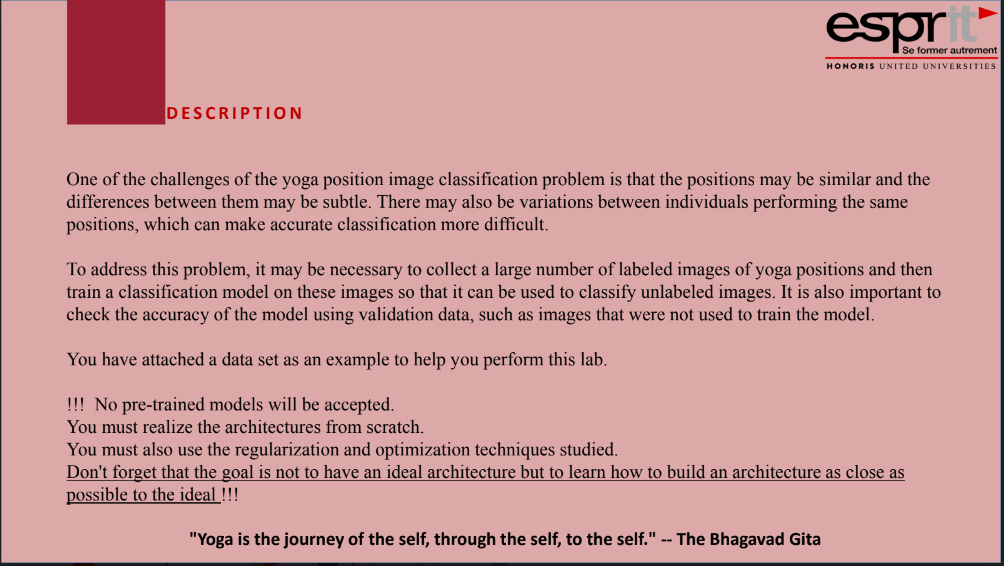

In [3]:
Image("/kaggle/input/prositesprit/Opera Snapshot_2023-03-11_191513_mail.google.com.png")

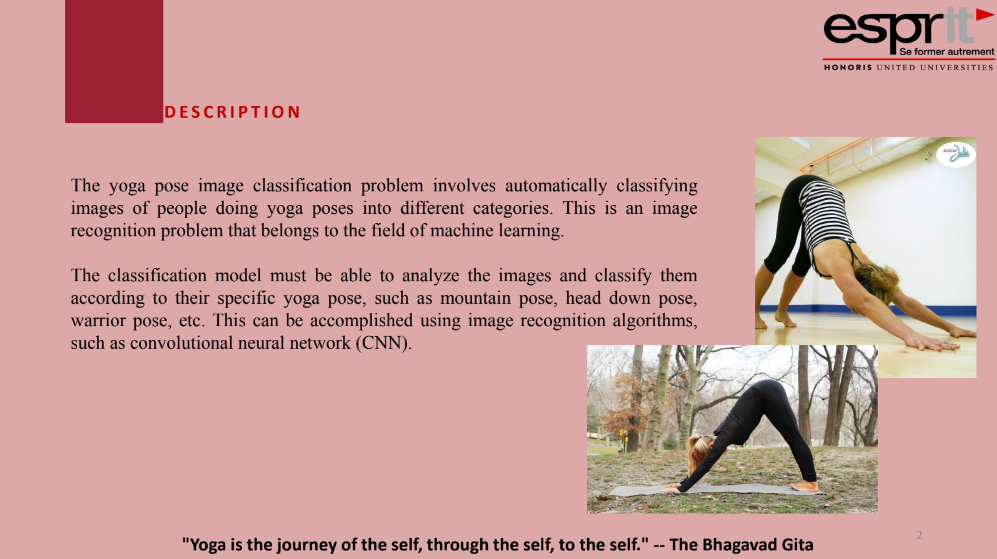

In [4]:
Image("/kaggle/input/prositesprit/Opera Snapshot_2023-03-11_191543_mail.google.com.png")

**Our Requirements**: 

    1-No Pre-trained models: 
    We will be creating everything from the beggining using libraries
    2-Architecture from scratch:
    Tying up the neural network based on the dataset, again, from scratch.

"Coincidently", the data provided was extracted from kaggle, So i'm gonna use that one!

# "Business" Understanding: 


The project calls for some business research, so let's do that!




**Definition of YOGA**:
Yoga is a group of physical, mental, and spiritual practices or disciplines which originated in ancient India.

There is a broad variety of yoga schools, practices, and goals in Hinduism, Buddhism, and Jainism. The term "Yoga" in the Western world often denotes a modern form of hatha yoga and yoga as exercise, consisting largely of the postures or asanas.

The practice of yoga has been thought to date back to pre-vedic Indian traditions, possibly in the Indus valley civilization around 3000 BCE. Yoga is mentioned in the Rigveda, and also referenced in the Upanishads, though it most likely developed as a systematic study around the 5th and 6th centuries BCE, in ancient India's ascetic and Śramaṇa movements. The chronology of earliest texts describing yoga-practices is unclear, varyingly credited to the Upanishads. The Yoga Sutras of Patanjali date from the 2nd century BCE, and gained prominence in the west in the 20th century after being first introduced by Swami Vivekananda. Hatha yoga texts began to emerge sometime between the 9th and 11th century with origins in tantra.

# Data Visualisation & Understanding

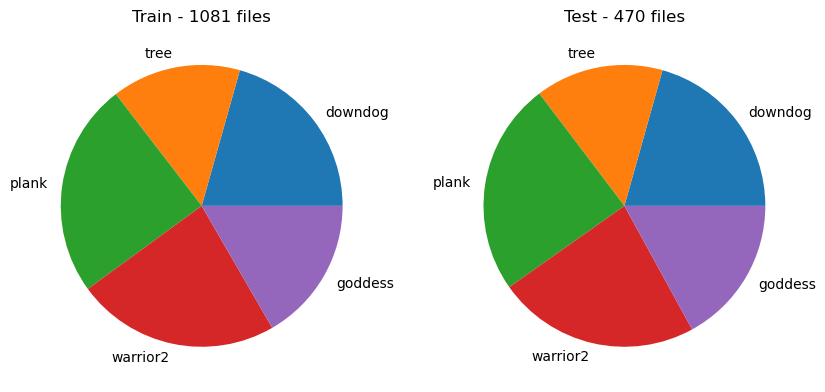

In [5]:
class_names = []
train_distrib = []
test_distrib = []

# for train
for dir in os.listdir(train_path):
    class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(train_path+dir+'/')) # count the files on the dir
    train_distrib.append(number) # append that number
    
# for test
for dir in os.listdir(test_path):
    #class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(test_path+dir+'/')) # count the files on the dir
    test_distrib.append(number) # append that number


plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(train_distrib, labels=class_names)
plt.title(f'Train - {sum(train_distrib)} files')
plt.subplot(1,2,2)
plt.pie(test_distrib, labels=class_names)
plt.title(f'Test - {sum(test_distrib)} files')
plt.show()

The data is distributed pretty well, **however**, The data seems a little low, We might have to create more!

As we can see, there are five classes i.e five yoga poses to classify:
* plank
* warrior2 
* downdog 
* tree
* goddess

Let's see an example of each pose and what they look like. for that, let's create a function to plot images from the dataset.


In [6]:
import matplotlib.image as mpimg 
import random
def plot_yoga_images(train_dir):
    plt.figure(figsize = (15,15))
    for i, col in enumerate(os.listdir(train_dir)):
        image = random.choice(os.listdir(train_dir + '/' + col))
        image_path = train_dir + '/' + col + '/' + image
        img = mpimg.imread(image_path)/255

        plt.subplot(3,3,i+1)
        plt.title(col)
        plt.imshow(img)
        plt.axis(False)
        i = i + 1

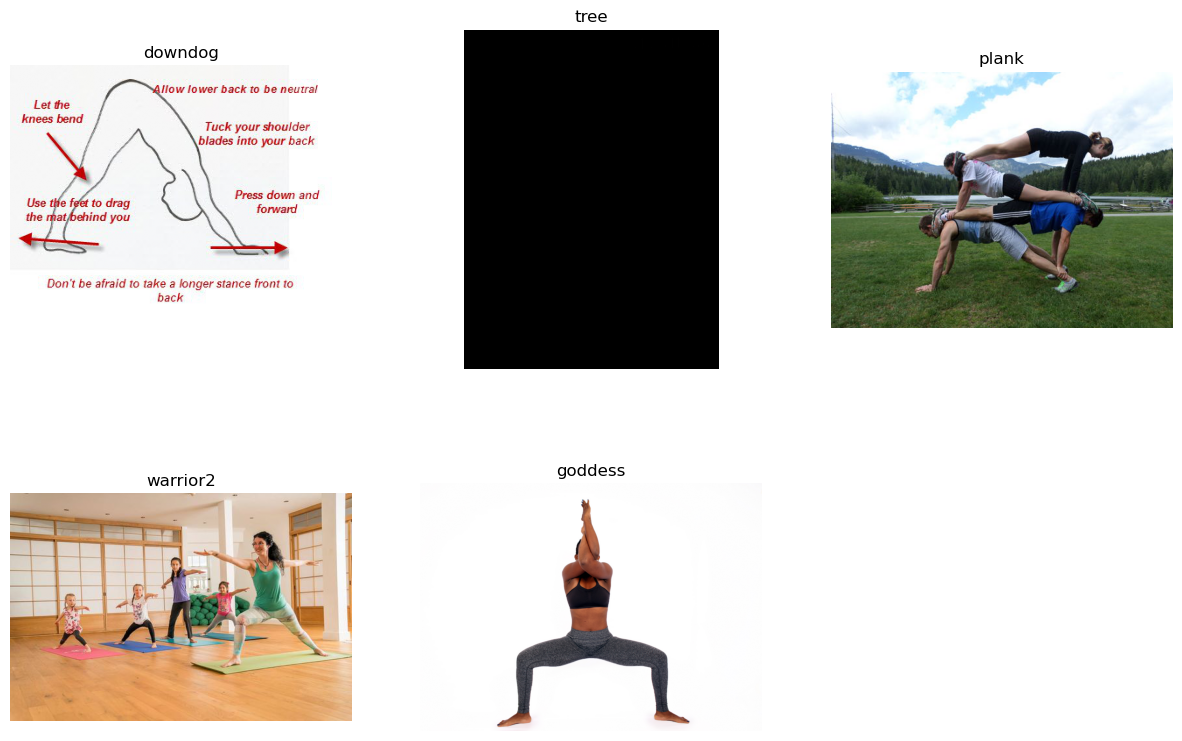

In [7]:
plot_yoga_images(train_path)

In [8]:
#Loading the full dataset
filenames,labels = [],[]

for dirname in os.listdir(f'{BASE_PATH}TRAIN'):
    for file in os.listdir(f'{BASE_PATH}TRAIN/{dirname}'):
        filenames.append(file)
        labels.append(dirname)

df_train = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
})

In [9]:
df_train.head()

filename   labels
0  00000335.jpg  downdog
1  00000287.png  downdog
2  00000382.jpg  downdog
3  00000233.jpg  downdog
4  00000310.png  downdog

In [10]:
df_train.labels.value_counts()

plank       266
warrior2    252
downdog     223
goddess     180
tree        160
Name: labels, dtype: int64

As stated earlier, All picture are labelized through 5 classes. 


Let's plot 5 pictures from each class, to see if any notible differences exist between the poses.

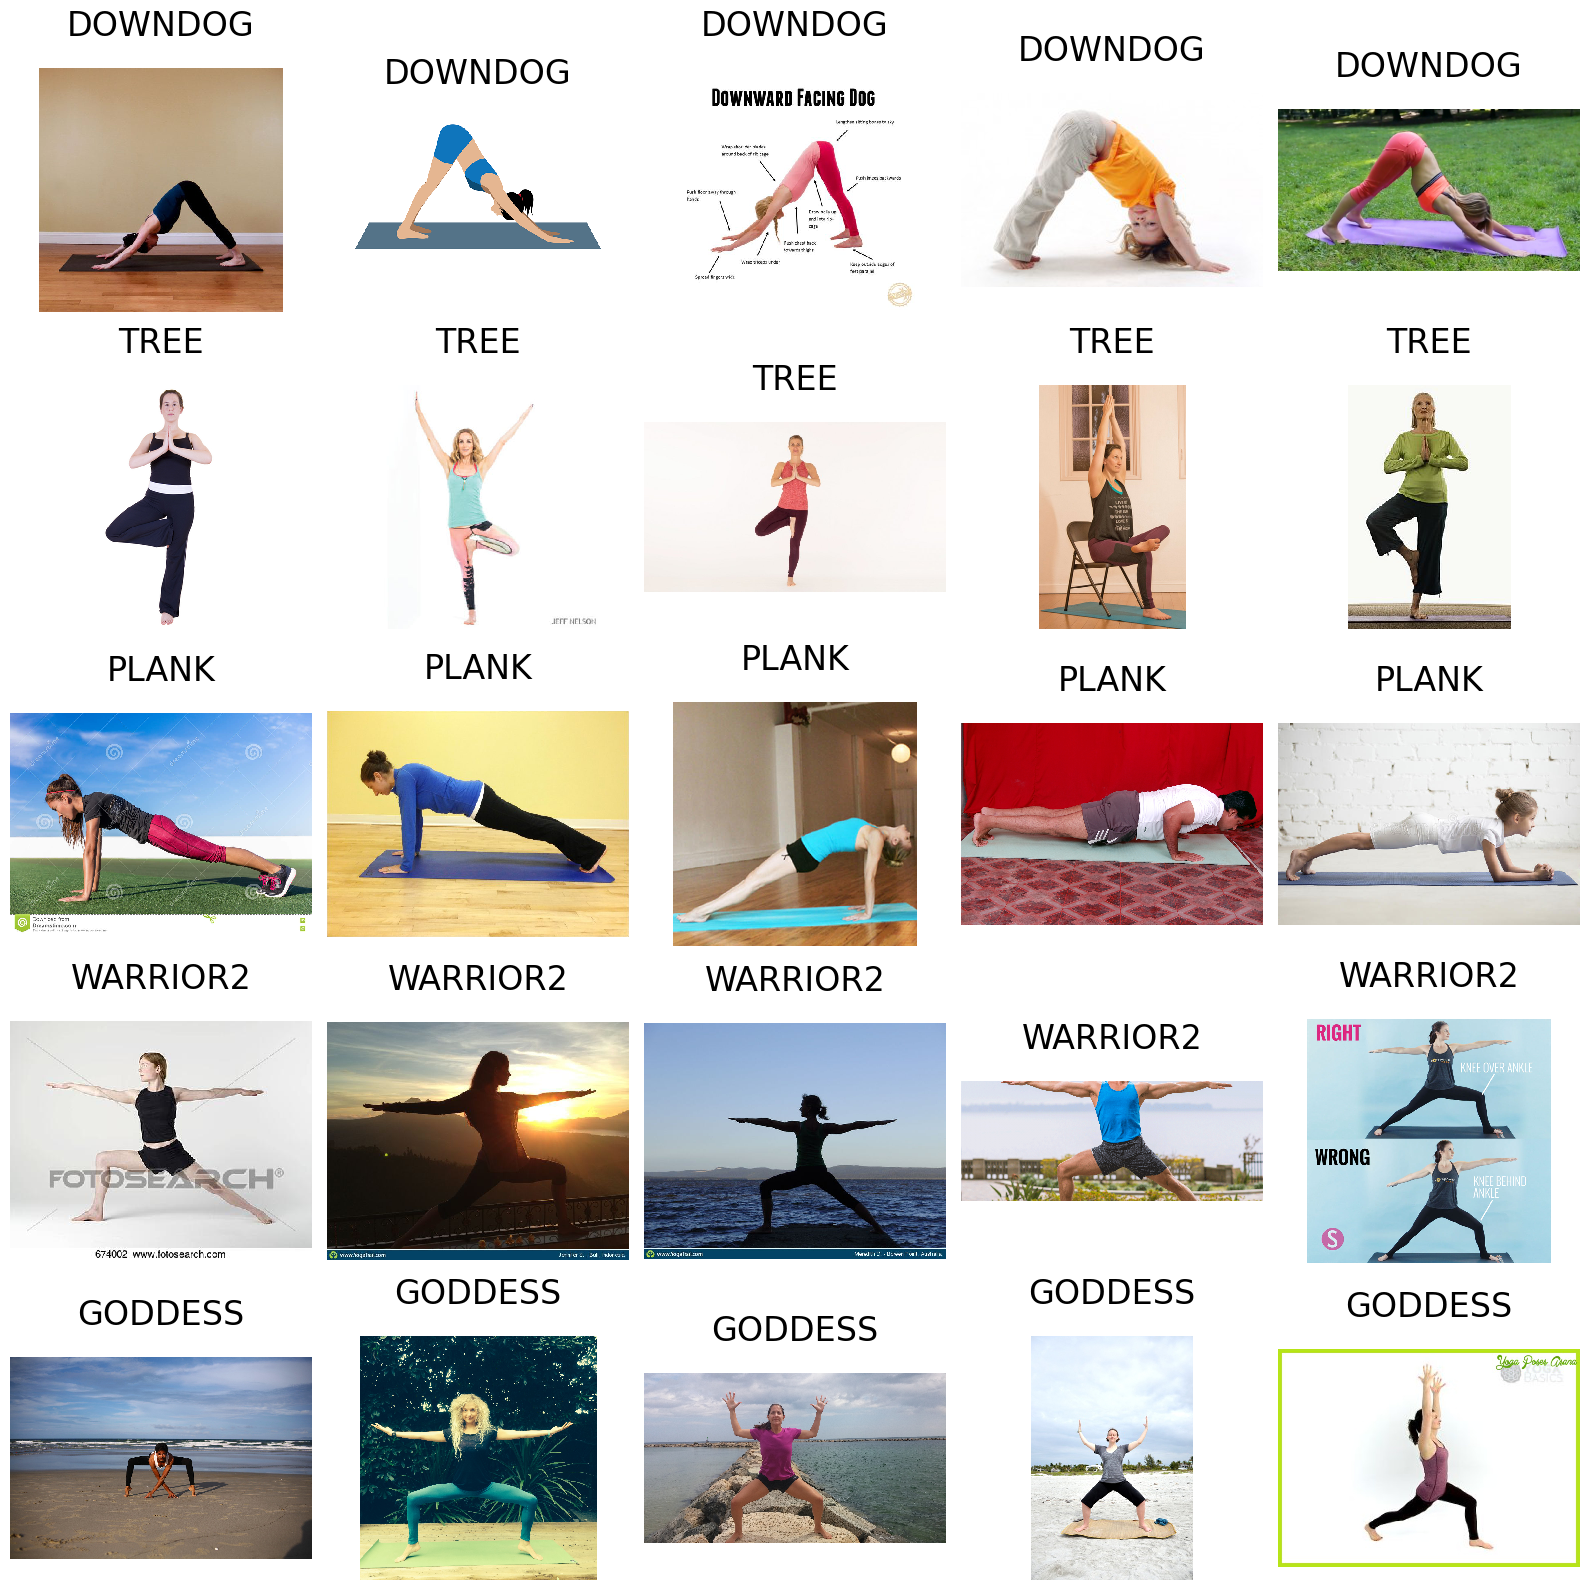

In [11]:
rows = 5 #Change these values for p
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
for i, row in enumerate(list(df_train.labels.unique())):
    for j, filename in enumerate(df_train[df_train.labels == row]['filename'].tolist()[:cols]):
        img = load_img(os.path.join(BASE_PATH,'TRAIN',row, filename))
        axs[i,j].matshow(img)
        axs[i,j].axis('off')
        axs[i,j].set_title(row.upper(), fontsize=24)
fig.tight_layout()

Most poses follow some principles, Some difference exists but they all follow the same general rule.


The pictures have different heights x widths, which could pose an issue for the model to differenciate from. 

# Data Preprocessing

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
import tensorflow as tf
import os
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Now, we'll create a function to check on the state of the images, just to see if there's any corrupted/blank/black images that might interfer with the model's performance

In [13]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [14]:
removeCorruptedImages(os.path.join(train_path,'downdog'))
removeCorruptedImages(os.path.join(train_path,'goddess'))
removeCorruptedImages(os.path.join(train_path,'plank'))
removeCorruptedImages(os.path.join(train_path,'tree'))
removeCorruptedImages(os.path.join(train_path,'warrior2'))
removeCorruptedImages(os.path.join(test_path,'downdog'))
removeCorruptedImages(os.path.join(test_path,'goddess'))
removeCorruptedImages(os.path.join(test_path,'plank'))
removeCorruptedImages(os.path.join(test_path,'tree'))
removeCorruptedImages(os.path.join(test_path,'warrior2'))

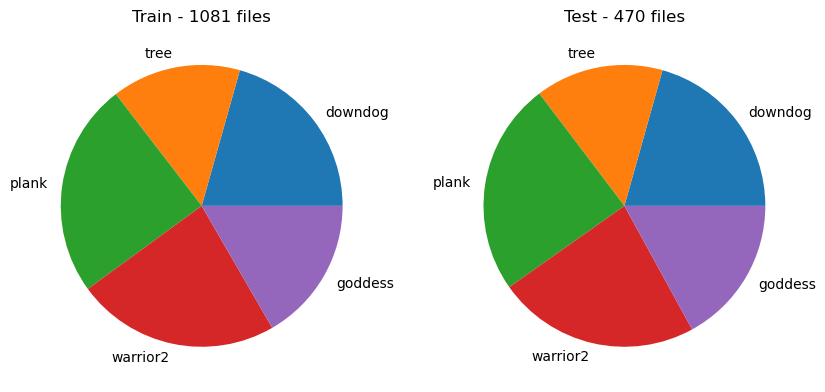

In [15]:
class_names = []
train_distrib = []
test_distrib = []

# for train
for dir in os.listdir(train_path):
    class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(train_path+dir+'/')) # count the files on the dir
    train_distrib.append(number) # append that number
    
# for test
for dir in os.listdir(test_path):
    #class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(test_path+dir+'/')) # count the files on the dir
    test_distrib.append(number) # append that number


plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(train_distrib, labels=class_names)
plt.title(f'Train - {sum(train_distrib)} files')
plt.subplot(1,2,2)
plt.pie(test_distrib, labels=class_names)
plt.title(f'Test - {sum(test_distrib)} files')
plt.show()

As we can see, the files count didn't change, this means that the data is rather clean. 
Now all that's left is to resize the images and normalize em.

**Equalization**:

*Histogram Equalization* is used for improving the contrast of any image, that is to make the dark portion darker and the bright portion brighter.


For a grey-scale image, each pixel is represented by the intensity value (brightness); that is why we can feed the pixel values directly to the HE function.



However, that is not how it works for an RGB-formatted color image. Each channel of the R, G, and B represents the intensity of the related color, not the intensity/brightness of the image as a whole. And so, running HE on these color channels is NOT the proper way. We should first separate the brightness of the image from the color and then run HE on the brightness. Now, there are already standardized colorspaces that encode brightness and color separately; so, we can use them here for separating and then re-merging the brightness

In [16]:
import cv2

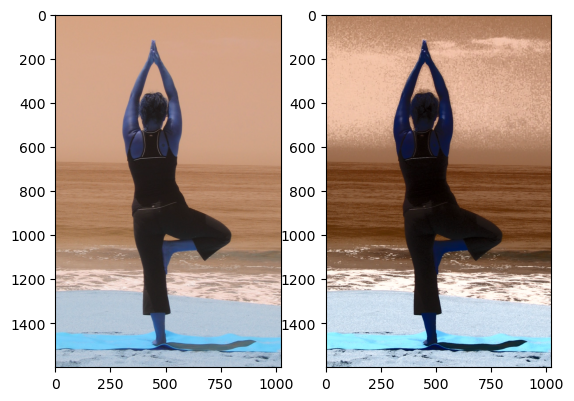

In [17]:
bgr_img = cv2.imread(train_path+'/tree/00000070.jpg')

# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCrCb)
 # equalize the histogram of the Y channel
ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

plt.subplot(121),plt.imshow(bgr_img)

plt.subplot(122),plt.imshow(equalized_img)
plt.show()

**Contrast is improved, However:** 

This poses 2 problems! 
In pictures with white backgrounds, this is the ideal way to work. But, Noise in images with colorful backgrounds is also boosted.
This can be solved by using CLAHE (Contrast Limited Adaptive Histogram Equalization)



Example Below!

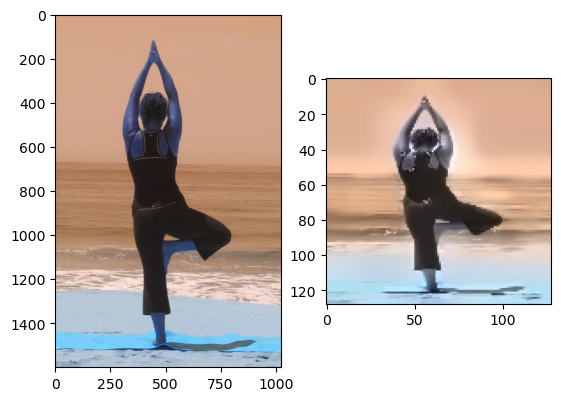

In [18]:
bgr_img = cv2.imread(train_path+'/tree/00000070.jpg')
# dsize
dsize = (128,128)
resized_image = cv2.resize(bgr_img,dsize)
# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
# create a CLAHE object 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Now apply on the YCrCb image 
ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

# Denoise is done to remove unwanted noise to better perform
equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)

plt.subplot(121),plt.imshow(bgr_img)
plt.subplot(122),plt.imshow(equalized_denoised_image)
plt.show()

Now let's create a function & a pipeline to apply these transformations to all images!

In [19]:
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            bgr_img = cv2.imread(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = cv2.resize(bgr_img,dsize)
            # convert from BGR color-space to YCrCb
            ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
            # create a CLAHE object 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # Now apply CLAHE object on the YCrCb image
            ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
            # convert back to BGR color-space from YCrCb
            equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
            # Denoise is done to remove unwanted noise to better perform
            equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
            
            images_data.append(equalized_denoised_image/255)
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label

In [20]:
train_images_data, train_images_label = preprocess_images(train_path)

Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


In [21]:
from sklearn import preprocessing
def encoding_targets(labels):
    le = preprocessing.LabelEncoder()
    images_label = le.fit_transform(labels)
    return images_label

In [22]:
class_names = os.listdir(train_path)
class_num = len(class_names)
train_images_label = encoding_targets(train_images_label)

# Developping the CNN Model

Usually, I'd use the data augmentation to scale the data to the model & rescale everything, However, to prove the usefulness of that method, I'm going to create the CNN model first, fit it & compile it then compare it before & after the data augmentation

In [23]:
import tensorflow.keras.layers as tfl
model = tf.keras.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
        
    
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),    
        
    
        tfl.Flatten(),
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
    
        tfl.Dense(class_num, activation='softmax')
        
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        1

# Training the Model (Before D.A)

**Kfold Cross Validation**

In [24]:
from tensorflow.keras.optimizers.legacy import Adam
#Setting metrics 
epochs = 20
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [25]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

In [26]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_images_data[train], train_images_label[train], batch_size=16, 
                        epochs=epochs, validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20


2023-04-17 19:34:44.383631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


54/54 [==============================] - 12s 14ms/step - loss: 2.1115 - accuracy: 0.4363 - val_loss: 1.6522 - val_accuracy: 0.2488
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 1.1707 - accuracy: 0.6377 - val_loss: 2.6321 - val_accuracy: 0.1521
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.8271 - accuracy: 0.7373 - val_loss: 1.9842 - val_accuracy: 0.2995
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.5757 - accuracy: 0.7975 - val_loss: 2.7108 - val_accuracy: 0.1751
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.4597 - accuracy: 0.8414 - val_loss: 1.6460 - val_accuracy: 0.2028
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2574 - accuracy: 0.9086 - val_loss: 1.7426 - val_accuracy: 0.3364
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2352 - accuracy: 0.9259 - val_loss: 4.5966 - val_accuracy: 0.1567
Epoch 8/20
54/54 [===========

2023-04-17 19:35:05.517824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


55/55 [==============================] - 1s 14ms/step - loss: 0.4671 - accuracy: 0.8786 - val_loss: 1.3489 - val_accuracy: 0.7037
Epoch 2/20
55/55 [==============================] - 0s 8ms/step - loss: 0.2354 - accuracy: 0.9156 - val_loss: 0.0864 - val_accuracy: 0.9630
Epoch 3/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1557 - accuracy: 0.9514 - val_loss: 0.1258 - val_accuracy: 0.9676
Epoch 4/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1080 - accuracy: 0.9653 - val_loss: 0.0974 - val_accuracy: 0.9815
Epoch 5/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1149 - accuracy: 0.9699 - val_loss: 0.0728 - val_accuracy: 0.9769
Epoch 6/20
55/55 [==============================] - 1s 10ms/step - loss: 0.0617 - accuracy: 0.9769 - val_loss: 0.0515 - val_accuracy: 0.9907
Epoch 7/20
55/55 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.9827 - val_loss: 0.1268 - val_accuracy: 0.9583
Epoch 8/20
55/55 [===========

In [27]:
print(f'> Mean_Training_Accuracy: {np.mean(acc_per_fold)*100} (+- {np.std(acc_per_fold)})')
print(f'> Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100} (+- {np.std(val_acc_per_fold)})')

> Mean_Training_Accuracy: 96.6090955734253 (+- 0.07356259167122045)
> Mean_Validation_Accuracy: 88.72791865468025 (+- 0.22664309367494215)


# Evaluation and Optimization

**Overfitting Issue**
> Training_Accuracy: 96.83709433674812 (+- 0.07093162113482086)


> Validation_Accuracy: 89.31212678551674 (+- 0.20364255237198184)

# Data Augmentation

So far we are working human postures and the flip of postures can change the definition of yoga poses. As a result model emits poor result when flip(horizontal_flip, vertical_flip) parameters are passed True

Let's fix that with data augmentation

In [28]:
dataAugmentaion = ImageDataGenerator(rotation_range = 10, zoom_range = 0.30, 
                                        fill_mode = "nearest", shear_range = 0.30) 

# Train Model After D.A

In [29]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit_generator(dataAugmentaion.flow(train_images_data[train], train_images_label[train], batch_size=16),
                                  epochs=epochs,
                                  validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
 4/54 [=>............................] - ETA: 1s - loss: 1.3831 - accuracy: 0.7656 

2023-04-17 19:35:46.920716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


54/54 [==============================] - 2s 30ms/step - loss: 1.5114 - accuracy: 0.6840 - val_loss: 6.3209 - val_accuracy: 0.4700
Epoch 2/20
54/54 [==============================] - 2s 34ms/step - loss: 1.1447 - accuracy: 0.6968 - val_loss: 0.2571 - val_accuracy: 0.9263
Epoch 3/20
54/54 [==============================] - 1s 26ms/step - loss: 0.9706 - accuracy: 0.7280 - val_loss: 0.4016 - val_accuracy: 0.8894
Epoch 4/20
54/54 [==============================] - 1s 23ms/step - loss: 0.7309 - accuracy: 0.7662 - val_loss: 0.1699 - val_accuracy: 0.9263
Epoch 5/20
54/54 [==============================] - 1s 23ms/step - loss: 0.6533 - accuracy: 0.7824 - val_loss: 0.1760 - val_accuracy: 0.9585
Epoch 6/20
54/54 [==============================] - 1s 24ms/step - loss: 0.5759 - accuracy: 0.8009 - val_loss: 0.2067 - val_accuracy: 0.9585
Epoch 7/20
54/54 [==============================] - 1s 23ms/step - loss: 0.5051 - accuracy: 0.8218 - val_loss: 0.2007 - val_accuracy: 0.9309
Epoch 8/20
54/54 [======

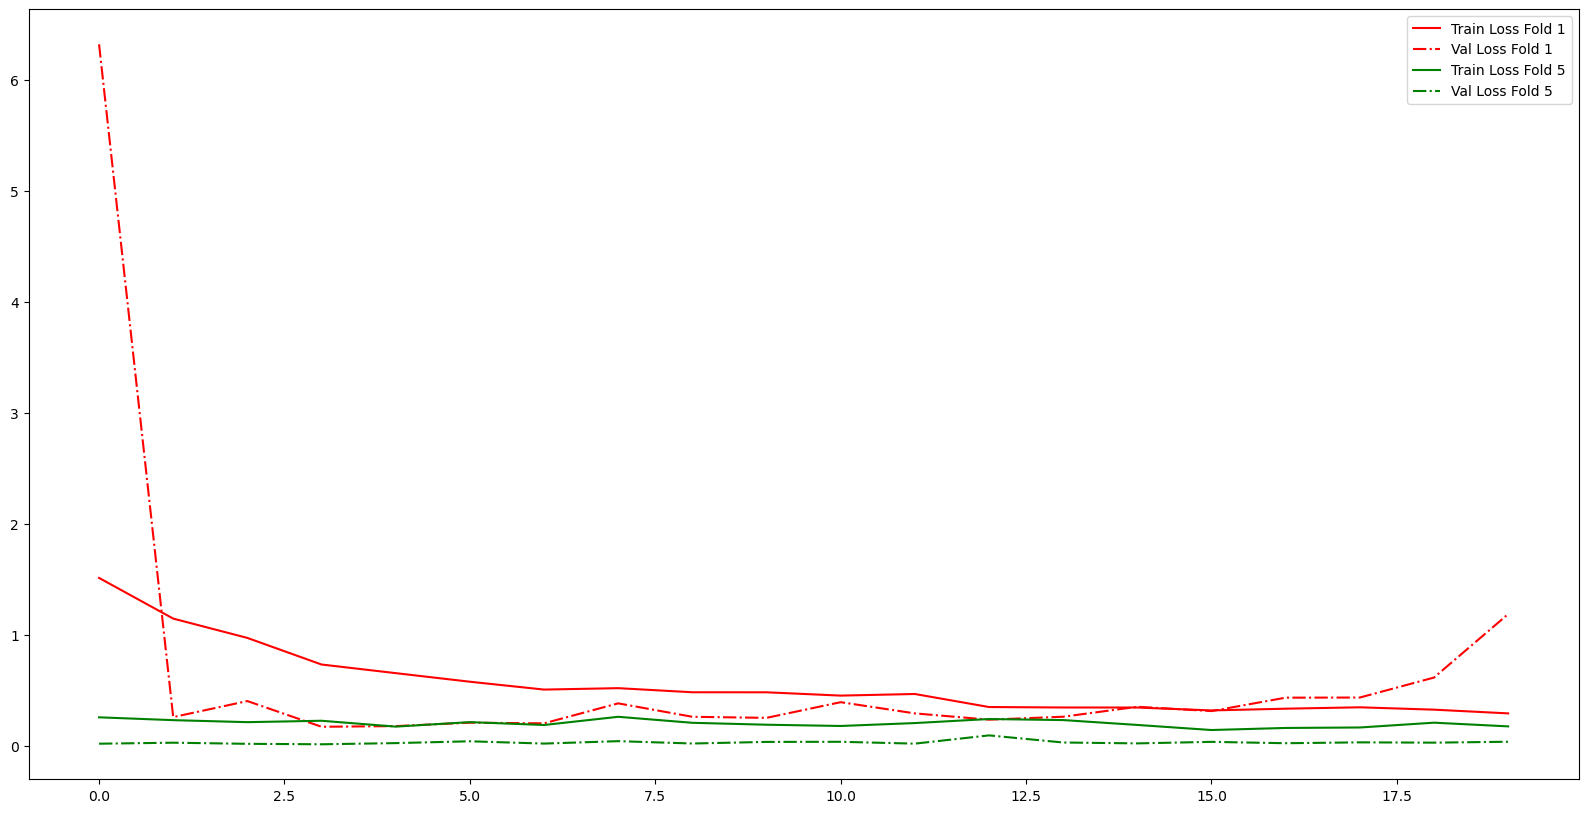

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(loss_per_fold[0], label='Train Loss Fold 1', color='red')
plt.plot(val_loss_per_fold[0], label='Val Loss Fold 1', color='red', linestyle = "dashdot")
plt.plot(loss_per_fold[2], label='Train Loss Fold 5', color='green')
plt.plot(val_loss_per_fold[2], label='Val Loss Fold 5', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

15/15 [==============================] - 0s 8ms/step
Test Data accuracy:  91.06382978723404

Confusion Matrix : 
[[ 95   0   1   0   1]
 [  1  60   4   4  11]
 [  3   0 106   2   4]
 [  1   0   0  68   0]
 [  2   4   1   3  99]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.93      0.98      0.95        97
        tree       0.94      0.75      0.83        80
       plank       0.95      0.92      0.93       115
    warrior2       0.88      0.99      0.93        69
     goddess       0.86      0.91      0.88       109

    accuracy                           0.91       470
   macro avg       0.91      0.91      0.91       470
weighted avg       0.91      0.91      0.91       470



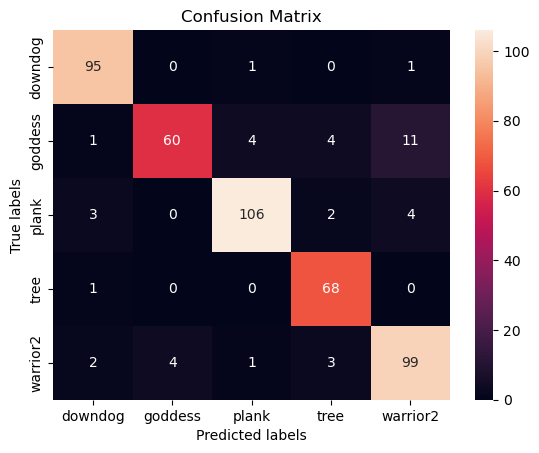

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);

# Model visualisation

Let's see the model at work. I found a java script library that helps.

The idea being, a chart will show up highlighting the image in red & blue shades. 
The shades of red color show parts that contributed positively and shades of blue color show parts that contributed negatively to the prediction of that category.

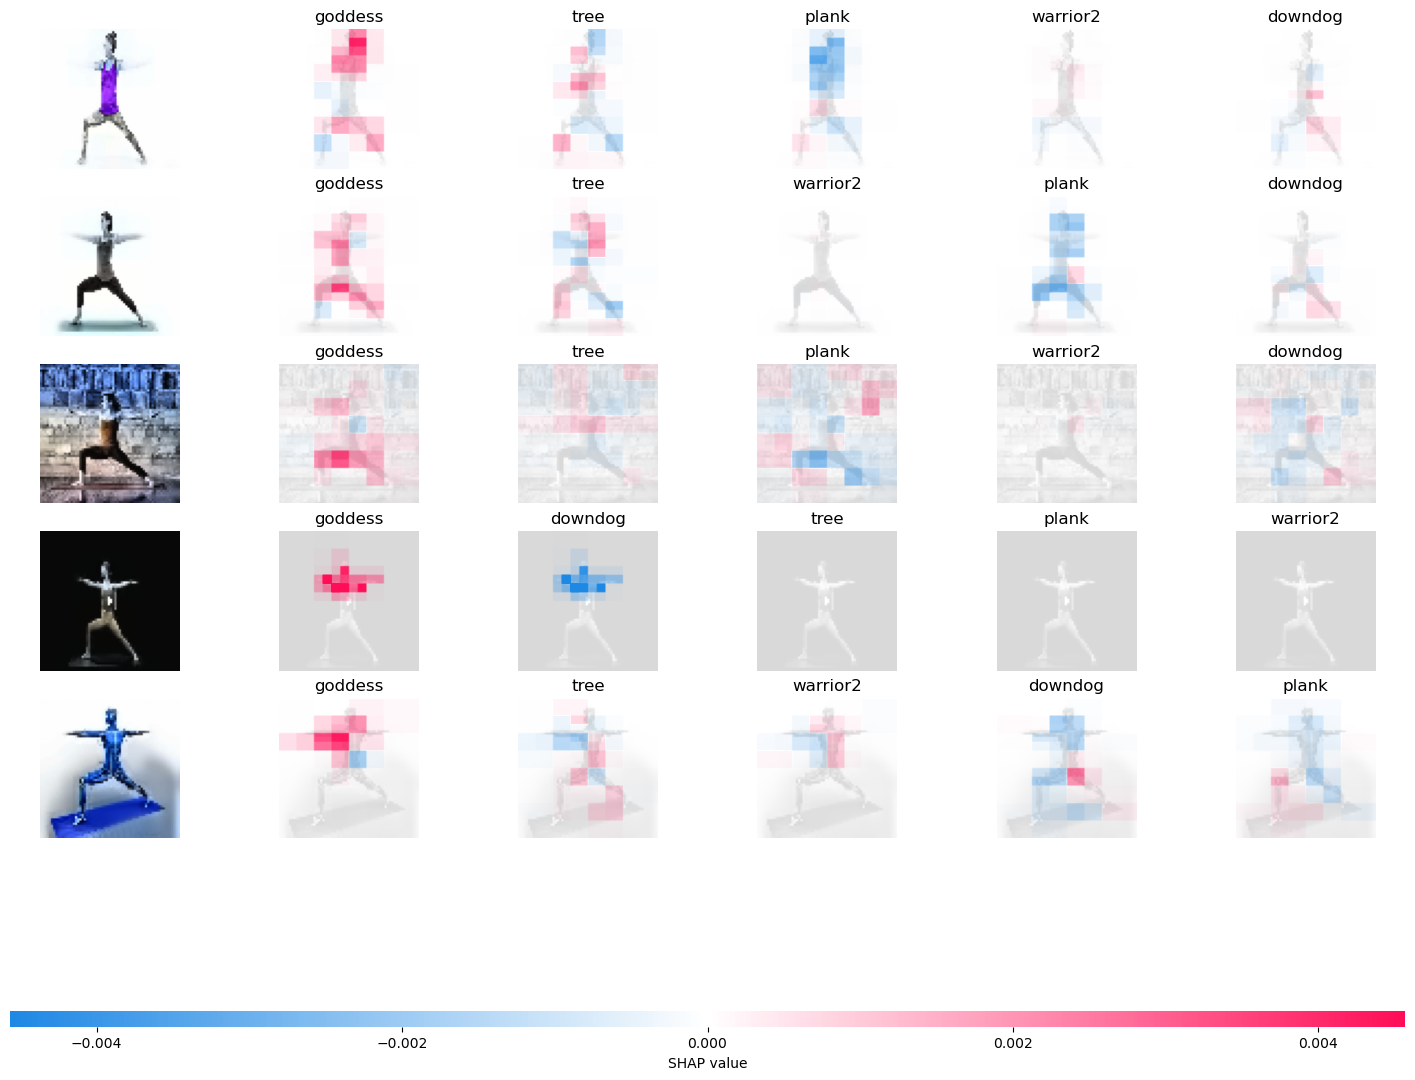

In [33]:
shap.initjs()
#Masker to mask parts of an image using blurring
masker = shap.maskers.Image("blur(64,64)", train_images_data[0].shape)
#Explainer() constructor by default creates an instance of Partition explainer
explainer = shap.Explainer(model, masker, output_names=class_names)
#generate shap values for images using the explainer object
shap_values = explainer(test_images_data[361:366], outputs=shap.Explanation.argsort.flip[:5])
shap.image_plot(shap_values)

1/1 [==============================] - 0s 21ms/step
[1. 0. 0. 0. 0.]


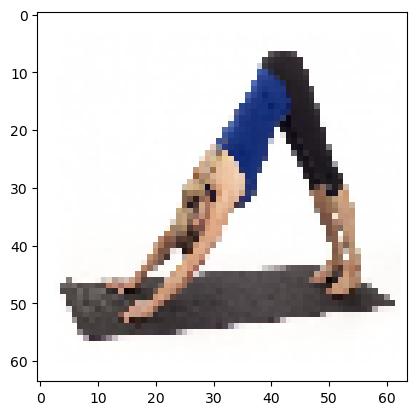

In [34]:
## from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import img_to_array, load_img

images = [] # path of the images
answers = [] # correct labels 

# 2 images per class

for clas in os.listdir(test_path):
    count = 0
    for image_path in os.listdir(test_path + clas + '/'):
        # append the image path
        images.append(test_path + clas + '/' + image_path)
        # append the answer
        answers.append(clas)
        count += 1 # count how many images have been appent
        if count == 2:
            break # only the two first ones

# load the image
image = load_img(images[0], target_size=(64, 64))
# copnvert to array
input_arr = img_to_array(image)
# convert as a batch for the model
input_arr = np.array([input_arr])  # Convert single image to a batch.
# and finally predict
prediction = model.predict(input_arr)
# squeeze because shape is (1,5)
print(np.squeeze(prediction))
plt.imshow(image)

1/1 [==============================] - 0s 21ms/step


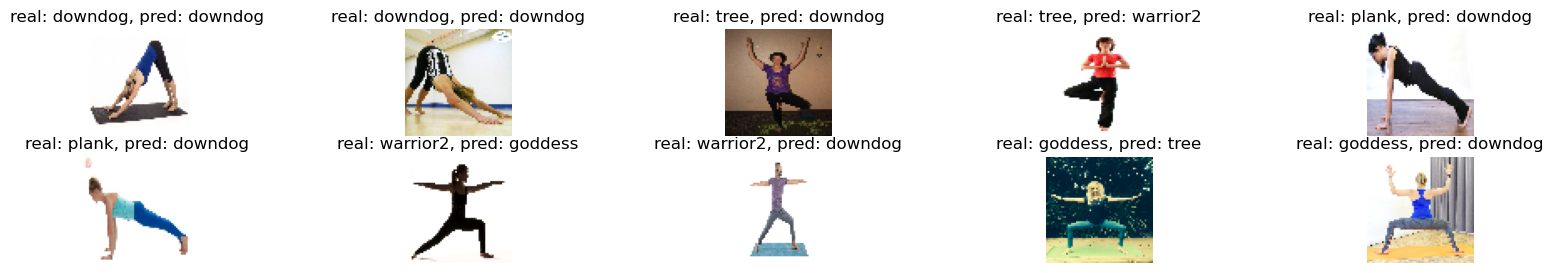

In [35]:
# recive the prediction and returns the label
def list_to_label(ls):
    lis = np.squeeze(ls) # remove extra dimension
    lis = list(lis)
    index = lis.index(1) # look for the 1
    return class_names[index]

def read_image(path, size=64):
    # load the image
    image = load_img(path, target_size=(size, size))
    # copnvert to array
    input_arr = img_to_array(image)
    # convert as a batch for the model
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    # and finally predict
    # prediction = model.predict(input_arr)
    return image, input_arr
    

# plot the predictions
plt.figure(figsize=(20,8))

for img_path, ans, i in zip(images, answers, np.arange(10)):
    img, arr = read_image(img_path) # read the image
    pred = model.predict(arr) # predict
    plt.subplot(5,5,i+1) # set the plot position
    plt.imshow(img) # plot the image
    # set the title with the pred and the answer
    plt.title(f'real: {ans}, pred: {list_to_label(pred)}')
    plt.axis('off')

plt.show()

1/1 [==============================] - 0s 21ms/step
[1. 0. 0. 0. 0.]


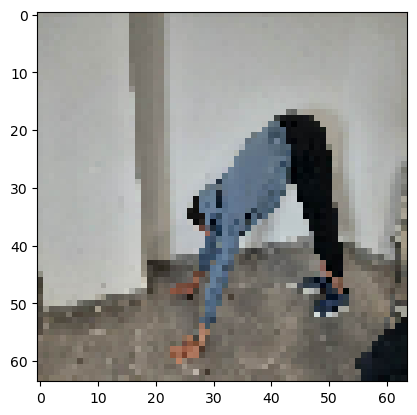

In [36]:
image = load_img("/kaggle/input/heniyoga/335992374_883558182876022_7864282186014935714_n.jpg", target_size=(64, 64))
# copnvert to array
input_arr = img_to_array(image)
# convert as a batch for the model
input_arr = np.array([input_arr])  # Convert single image to a batch.
# and finally predict
prediction = model.predict(input_arr)
# squeeze because shape is (1,5)
print(np.squeeze(prediction))
plt.imshow(image)